In [1]:
###### HI HELLO
import numpy as np # fast array library
import pandas as pd # data frames library
from pandas_ods_reader import read_ods #read ods tables

import matplotlib 
import matplotlib.pyplot as plt # plot library
import matplotlib.gridspec as gridspec
 
import subprocess # these 2 lines below load OS functionality
import sys
import json
import warnings

from IPython.display import display, HTML # screen on display in HTML library 

import sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.special as spec
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions
import scipy.optimize as optimize # optimazation library (not used)
from scipy import signal # noise filtering functions
from scipy import stats # statistics, for binning and fields calculation
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions


import ipywidgets as widgets # import 

import time # timing functions (for computation time)
from pytictoc import TicToc

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

In [3]:
tabla = pd.read_pickle('/home/fvega/Datos/blades/34913bb5677f08882949585aabd7ee16_data.pkl.xz', compression='xz')

In [16]:
tabla_FVR = pd.read_pickle('/home/fvega/Datos/blades/packing_fraction_045/tracks/34913bb5677f08882949585aabd7ee16.pkl.xz', compression='xz')

In [54]:
tabla.head()

,frame,track,x,y,r,vx,vy,theta,w,angle,mod_angle
0,1,0,24.174178,-338.839720,339.714636,0.475240,0.102544,0.517011,-103.544624,-103.544624,256.455376
1,2,0,24.332332,-338.813483,339.659127,0.482996,0.119120,0.771835,-103.707004,-207.251628,152.748372
2,3,0,24.489583,-338.778092,339.664638,0.513732,0.119429,1.023541,-104.025243,-311.276871,48.723129
3,4,0,24.649419,-338.737175,339.639903,0.548100,0.116960,1.289727,-104.458658,-415.735529,304.264471
4,5,0,24.815328,-338.694363,339.618718,0.563042,0.104241,1.533332,-104.966566,-520.702096,199.297904


In [33]:
np.max(np.array([ np.max(tabla_FVR[tabla_FVR.track==i].frame.values) for i in range(45)]))

24979

In [47]:
np.max(np.array([ np.max(tabla[tabla.track==i].frame.values) for i in range(45)]))

24975

In [48]:
parts = np.where(np.array([ np.max(tabla[tabla.track==i].frame.values) for i in range(45)])==24975)[0]

In [37]:
parts_FVR = np.where(np.array([ np.max(tabla_FVR[tabla_FVR.track==i].frame.values) for i in range(45)])==24979)[0]

In [49]:
parts == parts_FVR

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [5]:
! bat '/home/fvega/Datos/blades/34913bb5677f08882949585aabd7ee16_experiment_info.txt'

───────┬────────────────────────────────────────────────────────────────────────
       │ File: /home/fvega/Datos/blades/34913bb5677f08882949585aabd7ee16_experiment_info.txt
───────┼────────────────────────────────────────────────────────────────────────
   1   │ {
   2   │ "experiment_id": "34913bb5677f08882949585aabd7ee16",
   3   │ "original_file": "/mnt/beegfs/malopez/serieAspas/serieAspas_N45_p24_fps
       │ 900_1.cine",
   4   │ "date": "2038-01-19 10:39:20",
   5   │ "shape": [
   6   │ 1280,
   7   │ 800
   8   │ ],
   9   │ "fps": 900,
  10   │ "T_g": 3.253,
  11   │ "exposure": 1109,
  12   │ "n_frames": 24981,
  13   │ "recording_time": 27.756666666666668,
  14   │ "camera_distance": 0.95,
  15   │ "pixel_ratio": 1075.8620689655172,
  16   │ "particle_diameter_px": 78,
  17   │ "N": 45,
  18   │ "particle_shape": "rotating disk",
  19   │ "particle_diameter_m": 0.0725,
  20   │ "system_diameter": 0.725,
  21   │ "packing_fraction": 0.44999999999999996,
  22   │ "lights": "l

In [142]:
At = np.zeros(nt)

In [108]:
ipart = 0
vx = tabla[tabla.track==parts[ipart]].vx.values
for i in range(1,10000-1):
    At[i] = np.sum( np.diag(vx,k=i)[:nt,:nt].dot(vx) )/(nt-i)
    printp(str(i))
    #if (i%10==0):
    #    printp(str(i))

3

KeyboardInterrupt: 

In [140]:
def time_shift_mat_av(array, it):
    nt = len(array)
    return np.sum( np.diag(array , k=it)[:nt,:nt].dot(array) )/(nt-i-1)

def time_shift_np_av(array, denom,it):
    return np.mean(array[:-it] * array[it:])/denom

In [166]:
denom = np.mean(w[:10000] * w[:10000])

In [141]:
time_shift_np_av(W, denom, 1)

1.1436518555269706

In [159]:
At[0]=0

In [170]:
denom =  np.mean(W[:20000] * W[:20000])
for i in range(1,10000):
    At[i] = time_shift_np_av(W, denom, i)
    if i%100==0:
        printp(str(i))

9900

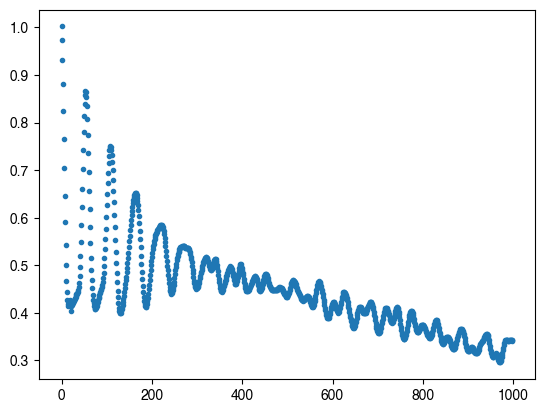

In [172]:
plt.plot(At[1:1000],'.')

In [130]:
time_shift_mat_av(W,1)

61.37913075867666

In [116]:
w = tabla[tabla.track==parts[0]].w.values

In [125]:
W = w - np.mean(w)

In [118]:
len(w[:-1] * w[1:])

24974

In [112]:
parts[1]

2

In [104]:
printp('hola')

hola

In [101]:
At[nt-1]

0.0

In [68]:
np.shape(np.diag(vx,k=2))

(24977, 24977)

In [70]:
iden = np.ones((4,4))

In [72]:
vec = np.array([1,2,3,4])

In [73]:
vec

array([1, 2, 3, 4])

In [77]:
np.diag(vec,k=1)[:4,:4]

array([[0, 1, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 3],
       [0, 0, 0, 0]])

In [89]:
vAt = np.diag(vx,k=1)[:24975,:24975].dot(vx)

In [91]:
vAt[-2]

0.05827046694773

In [86]:
vx[1]

0.4829963477843435

In [94]:
nt =len(vx)